In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import mdtraj
import urllib.request

# Download link
def download_link(doi, file):
    if "zenodo" in doi.lower():
        zenodo_entry_number = doi.split(".")[2]
        return 'https://zenodo.org/record/' + zenodo_entry_number + '/files/' + file
    else:
        print ("DOI provided: {0}".format(doi))
        print ("Repository not validated. Please upload the data for example to zenodo.org")
        return ""

In [2]:
def read_mapping_file(mapping_file, atom1, atom2):
    with open(mapping_file, 'rt') as mapping_file:
            for line in mapping_file:
                if atom1 in line:
                    m_atom1 = line.split()[1]
                    print(m_atom1)
                if atom2 in line: 
                    m_atom2 = line.split()[1]
                    print(m_atom2)
    return m_atom1, m_atom2

P
N
P
N
P
N
P
N
P
N
P
N


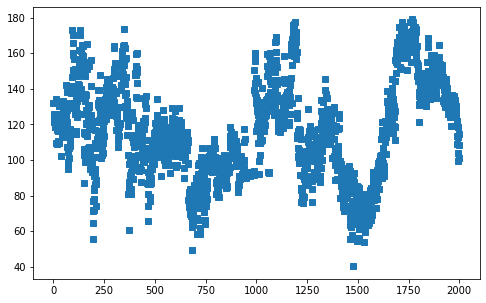

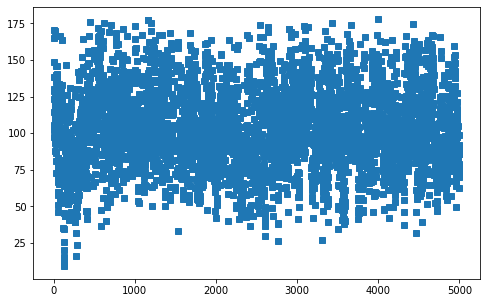

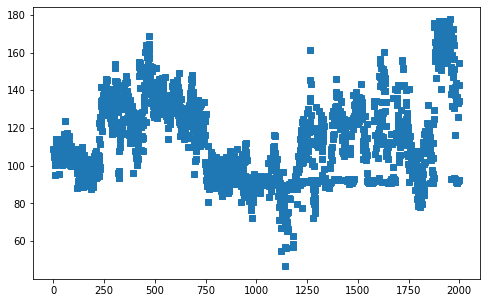

In [5]:
#Calculate the angle between PN vector and z-axis for each lipid residues

from OrderParameter import *


#def_file  = "/media/akiirikk/DATADRIVE1/tietokanta/MATCH/scripts/orderParm_defs/order_parameter_definitions_MODEL_CHARMM36_POPE.def"



lipids = {'POPE','POPS'}  #POPC puuttuu koska sen tpr file ei toimi,'POPG','POPS'
atom1 = 'M_G3P2_M'
atom2 = 'M_G3N6_M'

for subdir, dirs, files in os.walk(r'/media/akiirikk/DATADRIVE1/tietokanta/NMRlipidsIVPEandPG/Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.json"):
            READMEfilepath = subdir + '/README.json'
            with open(READMEfilepath) as json_file:
                readme = json.load(json_file)
                for molname in lipids:
#ei oo ehkä järkeä lukea näitä uudestaan tässä mutta olkoon nyt näin
                    doi = readme.get('DOI')
                    trj = readme.get('TRJ')
                    tpr = readme.get('TPR')
                    trj_url = download_link(doi, trj[0][0])
                    tpr_url = download_link(doi, tpr[0][0])
                    trj_name = '/media/akiirikk/DATADRIVE1/tietokanta/temp/DATAbankTST/POPCcharmm/tmp/0/'+readme.get('TRJ')[0][0]
                    tpr_name = '/media/akiirikk/DATADRIVE1/tietokanta/temp/DATAbankTST/POPCcharmm/tmp/0/'+readme.get('TPR')[0][0]
                    gro_name = '/media/akiirikk/DATADRIVE1/tietokanta/temp/DATAbankTST/POPCcharmm/tmp/0/'+readme.get('INI')[0][0]
                    
                    if readme['N' + molname] != 0:
                        mapping_file = "/media/akiirikk/DATADRIVE1/tietokanta/NMRlipidsIVPEandPG/scripts/mapping_files/mapping" + molname + "charmm.txt"
                        atoms = read_mapping_file(mapping_file, atom1 , atom2)
                        anglesMeanError = read_trj_PN_angles(molname, atoms, tpr_name, trj_name)
                        angles = anglesMeanError[0]
                        totalAverage = anglesMeanError[1]
                        totalAverageError = anglesMeanError[2]
#plottaa jakauma kaikista kulmista jokaiselle lipidille
                        fig= plt.figure(figsize=(8,5))
                        plt.plot(angles[1,:],"s")
                        

In [4]:
print(totalAverage)
print(totalAverageError)

114.16585142109147
13.765297516498011


In [1]:
import seaborn as snscolors 
colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}
#lipids = {'POPC','POPS','POPE','POPG'}
lipids = {'POPE','POPG','POPS','POPC'}

fig= plt.figure(figsize=(8,5))
for subdir, dirs, files in os.walk(r'/media/akiirikk/DATADRIVE1/tietokanta/NMRlipidsIVPEandPG/Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".md"):
            dict = eval(open(filepath).read())
            for lipid in lipids:
                if lipid in dict.get('SYSTEM'):
                    OPfilepath = subdir + '/OrderParameters.json'
                    print (dict.get('SYSTEM'))
                    with open(OPfilepath) as json_file:
                        data = json.load(json_file)
                    for key,value in data.items():
                        #print (key,value[0][0],value[0][2])
                        plt.gca().invert_yaxis()
                        plt.ylabel('S_CH')
                        if 'gamma' in key:
                            plt.plot(0,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(0,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'beta' in key:
                            plt.plot(1,value[0][0],"s",color=colors[lipid],label=dict.get('SYSTEM'))
                            plt.errorbar(1,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'alpha' in key:
                            plt.plot(2,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(2,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'g3' in key:
                            plt.plot(3,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(3,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'g2' in key:
                            plt.plot(4,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(4,value[0][0],yerr=value[0][2],color=colors[lipid])
                        if 'g1' in key:
                            plt.plot(5,value[0][0],"s",color=colors[lipid])
                            plt.errorbar(5,value[0][0],yerr=value[0][2],color=colors[lipid])
plt.legend(loc='best',ncol=2)
plt.savefig('/media/akiirikk/DATADRIVE1/tietokanta/NMRlipidsIVPEandPG/Figs/CHARMMfromLIPIDS.eps')
                    

NameError: name 'plt' is not defined

In [ ]:
colors = {'POPC' :'black','POPS':'red','POPE':'blue','POPG':'green'}
#lipids = {'POPC','POPS','POPE','POPG'}
#lipids = {'POPE','POPG','POPS','POPC'}
lipids ={'POPE'}

fig= plt.figure(figsize=(8,5))
for subdir, dirs, files in os.walk(r'/home/samuli/work/NMRlipids/NMRlipidsIVPEandPG/Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".md"):
            dict = eval(open(filepath).read())
            for lipid in lipids:
                if lipid in dict.get('SYSTEM'):
                    doi = dict.get('DOI')
                    trj = dict.get('TRJ')
                    tpr = dict.get('TPR')
                    trj_url = download_link(doi, trj[0][0])
                    tpr_url = download_link(doi, tpr[0][0])
                    trj_name = '/media/samuli/TOSHIBA/DataBank/TST/NMRlipidsIVbTST/'+dict.get('TRJ')[0][0]
                    tpr_name = '/media/samuli/TOSHIBA/DataBank/TST/NMRlipidsIVbTST/'+dict.get('TPR')[0][0]
                    gro_name = '/media/samuli/TOSHIBA/DataBank/TST/NMRlipidsIVbTST/conf.gro'
                    #response = urllib.request.urlretrieve(trj_url, trj_name)
                    #response = urllib.request.urlretrieve(tpr_url, tpr_name)
                    !echo System | gmx trjconv -f {trj_name} -s {tpr_name} -dump 0 -o {gro_name}
                    traj = mdtraj.load(trj_name, top = gro_name)
                    dihs = traj.topology.select("name == P or name == C11 or name == C12 or name == N")
                    index = [ [] for i in range(traj.topology.n_residues)]
                    #dihRESULT = [ [] for i in range(traj.topology.n_residues)]
                    dihRESULT = []
                    for residue in traj.topology.residues:
                        for i in dihs:
                            if(traj.topology.atom(i).residue == residue): 
                                index[residue.index].append(traj.topology.atom(i).index)
                        if(len(index[residue.index]) > 0):
                            #dihRESULT[residue.index].append(mdtraj.compute_dihedrals(traj,[index[residue.index]]))
                            dihRESULT.append(mdtraj.compute_dihedrals(traj,[index[residue.index]]))
                    print(dihRESULT)

In [ ]:
dihRESULTall = []
#dihRESULTsum=np.add(dihRESULT[5],dihRESULT[5]*-1)
#sum=0ihRESULTsum=np.add(dihRESULTsum,dihRESULT[i])
#print(dihRESULTsum)
#dihRESULTsum=np.add(dihRESULTsum,dihRESULT[9])
#print(dihRESULTsum)
#dihRESULTsum=np.add(dihRESULTsum,dihRESULT[10])
for i in range(traj.topology.n_residues):
    if(len(dihRESULT[i]) > 0):
        dihRESULTall=dihRESULT[0] + dihRESULT[i]
print(dihRESULTall)



In [ ]:
print(len(dihRESULT))
#print(dihRESULT[1])

In [ ]:
dist = [ 0 for i in range(len(dihRESULT))]
distSUM = [ 0 for i in range(50)]
for i in range(len(dihRESULT)):
    dist[i] =  plt.hist(dihRESULT[i], bins=50)
    distSUM = np.add(distSUM,dist[i][0])
    #print(dist[i][0])
    #print(distSUM)

In [ ]:
#totDIST=[distSUM,dist[0][1]]
#print(totDIST)
#print(dihRESULT[0])
#print(dist[0])
print(distSUM)
xaxis = [ 0 for i in range(len(dist[0][1])-1)]
for i in range(len(dist[0][1])-1):
    xaxis[i]=(dist[0][1][i])
    print(xaxis)
plt.plot(xaxis,distSUM)

In [ ]:
dihs = top.select("name == P or name == C11 or name == C12 or name == N")
index = [ [] for i in range(traj.topology.n_residues)]
dihRESULT = [ [] for i in range(traj.topology.n_residues)]
for residue in traj.topology.residues:
    for i in dihs:
        if(traj.topology.atom(i).residue == residue): 
            index[residue.index].append(traj.topology.atom(i).index)
    dihRESULT[residue.index] = mdtraj.compute_dihedrals(traj,[index[residue.index]])
    print(dihRESULT[residue.index])

In [ ]:
mdtraj.compute_dihedrals(traj,[dihs])

In [ ]:
top

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'